In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [26]:
df = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')

In [27]:
df.head()


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [28]:
df.shape


(1306122, 3)

In [29]:
cols = df.columns
for col in cols:
  print('Number of unique values:', df[col].nunique())

Number of unique values: 1306122
Number of unique values: 1306122
Number of unique values: 2


In [30]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2021-03-08 06:41:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-08 06:41:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-08 06:41:05--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [31]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [32]:
all_ques=" ".join(df['question_text'])
nspam_ques=" ".join(df.loc[df['target']==0,"question_text"])
spam_ques=" ".join(df.loc[df['target']==1,"question_text"])

In [34]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

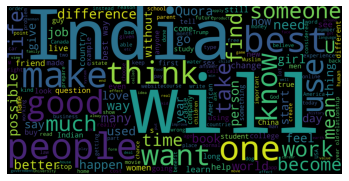

In [35]:

wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', 
                      width=4000,height=2000).generate(all_ques)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

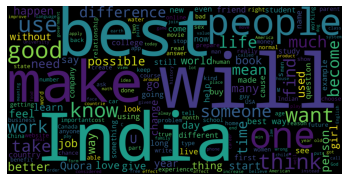

In [36]:
wordcloud1 = WordCloud(stopwords=STOPWORDS, background_color='black', 
                      width=4000,height=2000).generate(nspam_ques)

plt.imshow(wordcloud1)
plt.axis('off')
plt.show()\

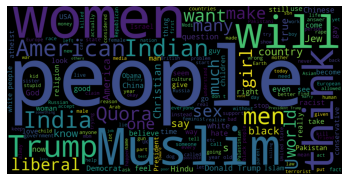

In [37]:
wordcloud2 = WordCloud(stopwords=STOPWORDS, background_color='black', 
                      width=4000,height=2000).generate(spam_ques)

plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

In [38]:
df['length']=[len(x) for x in df['question_text']]


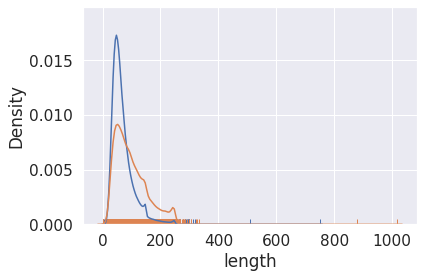

In [39]:
sns.distplot(df.loc[df['target']==0,'length'], hist=False, rug=True);
sns.distplot(df.loc[df['target']==1,'length'], hist=False, rug=True);

In [40]:
df['length'].max(), df['length'].min()


(1017, 1)

In [41]:
df.isnull().sum()


qid              0
question_text    0
target           0
length           0
dtype: int64

In [42]:
X = df['question_text'].values
y = df['target'].values

In [43]:
X


array(['How did Quebec nationalists see their province as a nation in the 1960s?',
       'Do you have an adopted dog, how would you encourage people to adopt and not shop?',
       'Why does velocity affect time? Does velocity affect space geometry?',
       ..., 'Is foam insulation toxic?',
       'How can one start a research project based on biochemistry at UG level?',
       'Who wins in a battle between a Wolverine and a Puma?'],
      dtype=object)

In [44]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [45]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X)
print(vocab_size)
# pad documents to a max length of 4 words
max_length = 20
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(len(padded_docs))

222162
1306122


In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, y, test_size=0.2, random_state=42)

In [48]:
embeddings_index = dict()
f = open("./glove.6B.100d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [49]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(222162, 100)


In [50]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
# define the model

model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=20, trainable=False))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           22216200  
_________________________________________________________________
flatten (Flatten)            (None, 2000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2001      
Total params: 22,218,201
Trainable params: 2,001
Non-trainable params: 22,216,200
_________________________________________________________________
None


In [60]:
import keras
h = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30, batch_size=512,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
        keras.callbacks.ModelCheckpoint('./Project 3 Spam filter for Quora questions/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
    ]
)


Epoch 1/30
2041/2041 [==============================] - 7s 3ms/step - loss: 0.1475 - accuracy: 0.9447 - val_loss: 0.1466 - val_accuracy: 0.9452
Epoch 2/30
2041/2041 [==============================] - 7s 3ms/step - loss: 0.1476 - accuracy: 0.9449 - val_loss: 0.1458 - val_accuracy: 0.9456
Epoch 3/30
2041/2041 [==============================] - 7s 3ms/step - loss: 0.1475 - accuracy: 0.9448 - val_loss: 0.1462 - val_accuracy: 0.9455
Epoch 4/30
2035/2041 [============================>.] - ETA: 0s - loss: 0.1476 - accuracy: 0.9449

KeyboardInterrupt: 

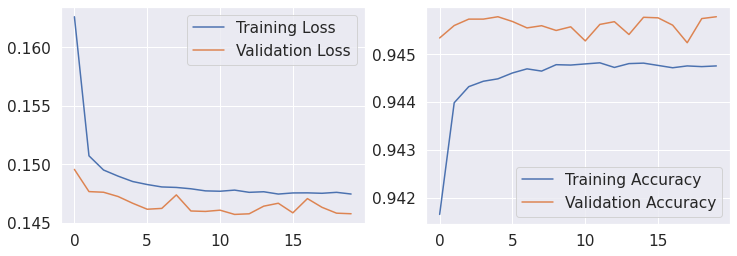

In [56]:
losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [61]:
model = keras.models.load_model('./Project 3 Spam filter for Quora questions/model_0.9452.h5')
preds = model.predict_classes(X_test)

In [62]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %f' % (accuracy*100))

8164/8164 [==============================] - 9s 1ms/step - loss: 0.1466 - accuracy: 0.9452
Accuracy: 94.519281


In [ ]:
preds[preds==1]

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))
print(accuracy_score(y_test, preds))

#                          Another Approach

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train=pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
test=pd.read_csv('../input/quora-insincere-questions-classification/test.csv')
print(train.shape,test.shape)
train

(1306122, 3) (375806, 2)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

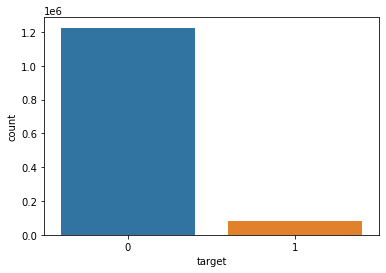

In [3]:
sns.countplot(train['target'])

In [4]:
print(len(train.question_text[train['target'] == 0]) /len(train['question_text']) * 100,'percent of not spam')
print(len(train.question_text[train['target'] == 1]) / len(train['question_text']) * 100,'percent of spam')

93.81298224821265 percent of not spam
6.187017751787352 percent of spam


In [5]:
train.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

In [8]:
import re

In [9]:
# Contraction replacement patterns
cont_patterns = [
    (b'(W|w)on\'t', b'will not'),
    (b'(C|c)an\'t', b'can not'),
    (b'(I|i)\'m', b'i am'),
    (b'(A|a)in\'t', b'is not'),
    (b'(\w+)\'ll', b'\g<1> will'),
    (b'(\w+)n\'t', b'\g<1> not'),
    (b'(\w+)\'ve', b'\g<1> have'),
    (b'(\w+)\'s', b'\g<1> is'),
    (b'(\w+)\'re', b'\g<1> are'),
    (b'(\w+)\'d', b'\g<1> would'),
]
patterns = [(re.compile(regex), repl) for (regex, repl) in cont_patterns]
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def prepare_for_char_n_gram(text):
    clean = bytes(text.lower(), encoding="utf-8")
    clean = clean.replace(b"\n", b" ")
    clean = clean.replace(b"\t", b" ")
    clean = clean.replace(b"\b", b" ")
    clean = clean.replace(b"\r", b" ")
    for (pattern, repl) in patterns:
        clean = re.sub(pattern, repl, clean)
    exclude = re.compile(b'[%s]' % re.escape(bytes(string.punctuation, encoding='utf-8')))
    clean = b" ".join([exclude.sub(b'', token) for token in clean.split()])
    clean = re.sub(b"\d+", b" ", clean)
    clean = re.sub(b'\s+', b' ', clean)
    clean = re.sub(b'\s+$', b'', clean)
    clean = re.sub(b"([a-z]+)", b"#\g<1>#", clean)
    clean = re.sub(b" ", b"# #", clean)  # Replace space
    clean = b"#" + clean + b"#"  # add leading and trailing #
    data['question_text'] = data['question_text'].apply(cleanHtml)
    return str(clean, 'utf-8')

In [11]:
from sklearn.model_selection import train_test_split
train, cv= train_test_split(train, test_size=0.2)
x_train=train.drop(['target'],axis=1)
y_train=train['target']
x_cv=cv.drop(['target'],axis=1)
y_cv=cv['target']

In [15]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()
reviews_tfidf = tf_idf_vect.fit_transform(x_train['question_text'].values)
reviews_tfidf1 = tf_idf_vect.transform(x_cv['question_text'].values)
reviews_tfidf2 = tf_idf_vect.transform(test['question_text'].values)
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
param_grid = {'alpha':[1000,100,10,1,0.1,0.01,0.001]} #params we need to try on classifier
gsv = GridSearchCV(nb,param_grid,cv=2,verbose=1,n_jobs=-1,scoring='f1')
gsv.fit(reviews_tfidf,y_train)
nb = BernoulliNB(alpha=0.1)
nb.fit(reviews_tfidf,y_train)
train_pred = nb.predict(reviews_tfidf)
cv_pred = nb.predict(reviews_tfidf1)
test_pred = nb.predict(reviews_tfidf2)
print("Train Set Accuracy: {}".format(metrics.accuracy_score(train_pred, y_train)))
print("Train Set ROC: {}".format(metrics.roc_auc_score(train_pred, y_train)))
print("Train Set F1 Score: {}\n".format(metrics.f1_score(train_pred, y_train)))
print("Validation Set Accuracy: {}".format(metrics.accuracy_score(cv_pred, y_cv)))
print("Validation Set ROC: {}".format(metrics.roc_auc_score(cv_pred, y_cv)))
print("Validation Set F1 Score: {}\n".format(metrics.f1_score(cv_pred, y_cv)))

Fitting 2 folds for each of 7 candidates, totalling 14 fits
Train Set Accuracy: 0.9224689132038851
Train Set ROC: 0.706633455996417
Train Set F1 Score: 0.5512496676415847

Validation Set Accuracy: 0.9180897693559192
Validation Set ROC: 0.6956044148332521
Validation Set F1 Score: 0.5252601451043909



Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



<AxesSubplot:>

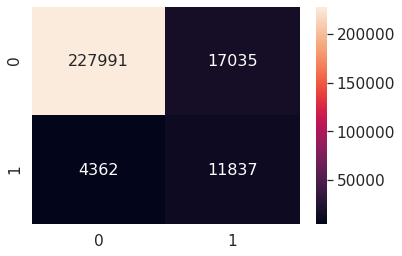

In [19]:
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_cv, cv_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')